<b><u><title>Redukcja wymiarów oraz selekcja cech kluczowych wielowymiarowych zbiorów dancyh.</title></b></u>

--------------------------------------------------------------------------

# Krótkie słowa wstępu.

Uprawianie Data Science w bioinformatyce oraz innych wymagających cierpliwości, specjalistycznej wiedzy oraz dotczących relanych problemów świata dziedzin nauki jest wciąż raczkującym podejściem. Rozumienie stosowanych metod niekiedy schodzi na dalszy plan co jest skutkiem goniących terminów oraz rzekomej złożoności matematyki stojącej za owymi rozwiązaniami.
Niekiedy metody te oparte na prostej statystyce, będąc zachwalane w publikacjach, tutorialach oraz na przestrzeniu forum internetowych nie powinny mieć zastosowania do większości danych biologicznych, lecz stanowią swoisty "trigger word", który ma za zadanie pokazać że badacz jest na czasie, "cool" oraz nie boi się interdyscyplinarności.


## Principal Component / Coordinate Analysis, czyli jak być fajnym ale nie koniecznie poprawnym.

Nie raz rozmawiając z osobami potencjalnie zajmującymi się podobnymi problemami badawczymi (biostatystycy, data scientists, biolodzy) natykałem się ze słowami rodem z pasty o [fanatyku wędkarstwa](https://copypasta.fandom.com/pl/wiki/M%C3%B3j_stary_to_fanatyk_w%C4%99dkarstwa.) "PCA jest król genomiki, tak jak lew jest król dżungli!". Jeśli słowa te pozostawiają u was cierpki wyraz twarzy, nie spojlerujcie mniej zaznajomionym kolegom dlaczego. Dzisiaj sami dojdą do tych wniosków.

## Podstawa użytkowania PCA

Jeśli wkleiłbym tutaj wzór na PCA, połowa z was by zasnęła, 1/4 się zaśmiała a 1/4 wyszła. Wklejanie tak skomplikowanych wzorów mija się z celem. Jeśli ktoś z was będzie chciał faktycznie zgłębić jego tajemnicę to [tutaj](https://www.youtube.com/watch?v=kw9R0nD69OU) oraz [tam](https://www.youtube.com/watch?v=rng04VJxUt4) znajdziecie ważniejsze informacje na temat jego działania. Moim dzisiejszym zadaniem jest przekazanie wam intuicji dotyczącej tego kiedy używać tego algorytmu a kiedy nie. Zatem do rzeczy, macie 5 minut żeby przypomnieć sobie kluczową różnicę pomiędzy testem parametrycznym takim jak ANOVA a nie parametrycznym takim jak Kruskal-Wallis test. Uścisk ręki prezesa temu kto najprościej powie jak sprawdzić kiedy stosować jeden test a kiedy drugi. Czas start! Odpalamy komórkę poniżej i lecimy z tematem!





In [2]:
import time
for i in range(5):
  if i < 4:
    print("{} min left".format(5 - i))
    time.sleep(60)
  else:
    print("{} min left".format(5 - i))
    time.sleep(60)
    print("Czas na odpowieź")

5 min left


KeyboardInterrupt: ignored

# Sprawdźmy czy macie rację
Poniżej zaimportujemy pewien zestaw danych.
Korzystając z dokumentacji [`sklearn`](https://scikit-learn.org/stable/) i [`scipy`](https://www.scipy.org/docs.html) będziecie dziś na nim operować, tak aby stworzyć najlepszy możliwy model prostej regresji logistycznej.

Dane są wielowymiarowe i należy wyciągnąć z nich jedyne przydatne informacje do klasyfikacji.

Dla utrudnienia użyjemy datasetu Wisconsin Breast Cancer bez nazw kolumn

In [3]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data & wget http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names

--2019-11-22 13:42:00--  http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names
--2019-11-22 13:42:00--  http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4708 (4.6K) [application/x-httpd-php]
Saving to: ‘wdbc.names’

wdbc.names          100%[===================>]   4.60K  --.-KB/s    in 0s      

2019-11-22 13:42:00 (400 MB/s) - ‘wdbc.names’ saved [4708/4708]

128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124103 (121K) [application/x-httpd-php]
Saving to: ‘wdbc.data’

wdbc.data           100%[===================>] 121.19K   311KB/s  

In [4]:
# Importujemy bibliotekę pandas by móc działać na data frames
import pandas

# Wczytujemy plik csv z usunięciem informacji o nazwach kolumn
data = pandas.read_csv("wdbc.data", header = None)
cols = data.columns.to_list()

# Nadajemy "dummy" nazwy kolumn
for i in range(len(cols)):
  if i == 0:
    cols[i] = "Index"
  elif i == 1:
    cols[i] = "Tumor"
  else:
    cols[i] = "Feature {}".format(i-1)
data.columns = cols

# Czyścimy co nieco kolumnę kategorii
data.Tumor = data.Tumor.replace("M", "Malignant")
data.Tumor = data.Tumor.replace("B", "Benign")
column_idx_names = data.columns

# Usuwamy ID pacjenta i przywracamy nazwy kolumn zgodne z indeksami
data = data.iloc[:,1:]

# Wyświetlamy pierwsze 10 rzędów data frame'u
data.head(10)

,Tumor,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,Feature 30
0,Malignant,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,Malignant,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,Malignant,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,Malignant,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,Malignant,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,Malignant,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,Malignant,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,Malignant,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,Malignant,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,Malignant,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


In [6]:
# Printujemy wartości unikalne kolumny zawierającej kategorie
print(data.Tumor.unique())

['Malignant' 'Benign']


In [0]:
# Metadane, nie obowiązkowe do zapoznania się
with open("wdbc.names","rb") as fh:
  for line in fh.readlines():
    print(line)

## Importowanie bibliotek
Korzystając z dobrodziejstw Google Collab zaimportujemy biblioteki bez których bylibyśmy jak pijane dziecko we mgle.


In [0]:
import pandas
from scipy import stats
import itertools
from sklearn import preprocessing, linear_model, model_selection, metrics
from sklearn import decomposition, ensemble, feature_selection
from sklearn.manifold import MDS
import numpy
from matplotlib import pyplot
import operator
%matplotlib inline

**Zadanie 1.**
Sprawdź rozkład kolumn z datasetu WBC przy użyciu odpowiedniej funkcji z biblioteki `scipy.stats`

**Zadanie 2.**
Wytłumacz co oznacza wynik kodu z zadania pierwszego


## Tworzenie funkcji do sprawdzenia rozkładu zmiennych dla każdej z obecnych klas

In [8]:
def StratifiedDistributionCheck(dataframe, list_of_tumors):
  for tumor in list_of_tumors:
    df = dataframe[dataframe.Tumor == tumor]
    print("Results for {} tumor type\n -----------------------\n".format(tumor))
    for column in df.columns:
      if column == "Tumor":
        None
      else:
        p = stats.shapiro(df.loc[:,column])[1]
        print("{0:s} Shapiro-Wilk test p-value equals {1:.3f}\n".format(
            column,p))
        if p > 0.05:
          print("Column is at least sampled from Gaussian distribution\n\n")
        else:
          print("Column's distribuition is not Gaussian\n\n")

StratifiedDistributionCheck(data,data.Tumor.unique())

Results for Malignant tumor type
 -----------------------

Feature 1 Shapiro-Wilk test p-value equals 0.002

Column's distribuition is not Gaussian


Feature 2 Shapiro-Wilk test p-value equals 0.000

Column's distribuition is not Gaussian


Feature 3 Shapiro-Wilk test p-value equals 0.000

Column's distribuition is not Gaussian


Feature 4 Shapiro-Wilk test p-value equals 0.000

Column's distribuition is not Gaussian


Feature 5 Shapiro-Wilk test p-value equals 0.021

Column's distribuition is not Gaussian


Feature 6 Shapiro-Wilk test p-value equals 0.000

Column's distribuition is not Gaussian


Feature 7 Shapiro-Wilk test p-value equals 0.000

Column's distribuition is not Gaussian


Feature 8 Shapiro-Wilk test p-value equals 0.000

Column's distribuition is not Gaussian


Feature 9 Shapiro-Wilk test p-value equals 0.000

Column's distribuition is not Gaussian


Feature 10 Shapiro-Wilk test p-value equals 0.000

Column's distribuition is not Gaussian


Feature 11 Shapiro-Wilk test p

In [0]:
# Uzupełnij kod funkcji przedstawionej poniżej

def StratifiedDistributionCheck(dataframe, list_of_tumors):
  for tumor in list_of_tumors:
    df = dataframe[dataframe.Tumor == tumor]
    print("Wyniki dla {} tumor type\n -----------------------\n".format(tumor))
    for column in df.columns:
      if column == "<NAZWA_KOLUMNY_DO_POMINIĘCIA>":
        None
      else:
        p = stats.<NAZWA_FUNKCJI>(df.loc[:,column])[1]
        print("{0:s} <NAZWA_TESTU> test p-value wynosi {1:.3f}\n".format(
            column,p))
        if p > 0.05:
          print("Twoje wytłumaczenie wyniku działania konstrukcji warunkowej")
        else:
          print("Twoje wytłumaczenie wyniku działania konstrukcji warunkowej")

StratifiedDistributionCheck(data,data.Tumor.unique())

# Data Science w praktyce
W tej części zobaczycie (i mam nadzieję też zrozumiecie, co z czym się je)

## Definiowanie modelu regresji logistycznej z użyciem `sklearn`
Stworzymy teraz funkcje zwracające model oraz wynik działania modelu na danych wejściowych, tak aby móc porównać wpływ różnych metod redukcji wymiarów na dane (oraz zobaczyć jak przebiega klasyfikacja w przypadku oryginalnych danych).

Najpierw jednak rozbijemy DataFrame na 2 macierze, zawierające dane numeryczne, potrzebne do wytrenowania i testowania modelu, oraz zawierające binarnie enkodowane typy guza.

In [9]:
X = data.iloc[:,1:].values
Y_str = data.iloc[:,0]
lb = preprocessing.LabelBinarizer()
lb.fit(Y_str)
print("Typy guzów do binaryzacji\n {} = 0\n {} = 1".format(lb.classes_[0],
                                                               lb.classes_[1]))
Y = lb.transform(Y_str)
print("\nRozmiar matrycy X\n{}".format(X.shape))
print("\nPierwsze dwa rzędy X\n{}".format(X[:2,:]))
print("\nRozmiar matrycy Y\n{}".format(Y.shape))
print("\nPierwsze dwa typy guzów Y\n{}".format(Y[:2,:]))


Typy guzów do binaryzacji
 Benign = 0
 Malignant = 1

Rozmiar matrycy X
(569, 30)

Pierwsze dwa rzędy X
[[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 1.326e+03 8.474e-02 7.864e-02 8.690e-02
  7.017e-02 1.812e-01 5.667e-02 5.435e-01 7.339e-01 3.398e+00 7.408e+01
  5.225e-03 1.308e-02 1.860e-02 1.340e-02 1.389e-02 3.532e-03 2.499e+01
  2.341e+01 1.588e+02 1.956e+03 1.238e-01 1.866e-01 2.416e-01 1.860e-01
  2.750e-01 8.902e-02]]

Rozmiar matrycy Y
(569, 1)

Pierwsze dwa typy guzów Y
[[1]
 [1]]


Poniższa funkcja zwracać będzie gotowy wytrenowany model, wynik działania tego modelu oraz metryki do późniejszego benchmarku

In [0]:
def LogitModel(X, Y, penalty = "l1", reg = 0.2, solver = "liblinear",
               random_state = 2137, n_iter = 100, split = 0.7, verbose = 1):
  Y = Y.ravel()
  c = 1 - reg
  s = 1 - split
  clf = linear_model.LogisticRegression(penalty = penalty,
                                        C = 1-reg,
                                        solver = solver,
                                        random_state = random_state,
                                        max_iter = n_iter,
                                        verbose = verbose,
                                        )
  X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y,
                                                                      test_size = s,
                                                                      random_state = random_state)
  
  clf = clf.fit(X_train, Y_train)
  Y_pred = clf.predict(X_test)
  scores = {}
  scores["Mean Accuracy"] = clf.score(X_test, Y_test)
  scores["F1"] = metrics.f1_score(Y_test, Y_pred)
  scores["AUC"] = metrics.roc_auc_score(Y_test, Y_pred)
  scores["Confusion Matrix"] = metrics.confusion_matrix(Y_test, Y_pred)
  scores["ROC Curve"] = metrics.roc_curve(Y_test, Y_pred)
  
  pyplot.matshow(scores["Confusion Matrix"])
  pyplot.title("Confusion Matrix")
  pyplot.colorbar()
  pyplot.ylabel("True label")
  pyplot.xlabel("Predicted Label")
  pyplot.show()

  fpr, tpr, _ = metrics.roc_curve(Y_test.ravel(), Y_pred.ravel())
  roc_auc = metrics.auc(fpr, tpr)

  pyplot.figure()
  lw = 2
  pyplot.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  pyplot.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  pyplot.xlim([0.0, 1.0])
  pyplot.ylim([0.0, 1.05])
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  pyplot.title('Receiver operating characteristic example')
  pyplot.legend(loc="lower right")
  pyplot.show()


  for i, v in scores.items():
    if i == "Confusion Matrix":
      print("{}\n{}".format(i,v))
    elif i == "ROC Curve":
      None
    else:
      print("{0:s} metic has value of {1:.3f}".format(i,v))
  return (clf, Y_test, Y_pred, scores)
  


## Redukcja wymiarowości danych

**Zadanie 3**

Zastosuj [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [MDS](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html), [Feature Selection bazujące na drzewach decyzyjnych](https://scikit-learn.org/stable/modules/feature_selection.html#tree-based-feature-selection) oraz Infinite Feature Selection na danych wejściowych. Empirycznie dobierz najlepsze parametry (wskazane w kodzie)


**Zadanie 4** 

Zastosuj funkcję `LogitModel` na danych otrzymanych w zadaniu trzecim i określ który model dał najlepsze wyniki oraz jaka może być tego przyczyna.



<u>Dla przypomnienia - wymiarowość pełnego zestawu danych</u>


In [11]:
X.shape[1]

30

### Infinite Feature Selection jako metoda alternatywna
obraz.png

In [41]:
def InfiniteFeatureSelection(X, n_features, alpha):
  all_permutations = list(itertools.permutations(range(X.shape[1]), 2))
  importance_scores = []
  max_var_idx = []
  feature_idx = list(range(n_features))
  X_important = numpy.zeros(shape = (X.shape[0], n_features))
  
  for element in all_permutations:
    element1 = element[0]
    element2 = element[1]
    v1 = numpy.var(X[:,element1])
    v2 = numpy.var(X[:,element2])

    max_var = max(v1,v2)
    if max_var == v1:
      max_var_idx.append(str(element1))
    else:
      max_var_idx.append(str(element2))
    
    spearman_coef, p = stats.spearmanr(X[:,element1], X[:,element2])
    reg_max_var = numpy.multiply(alpha,max_var)
    reg_spearman_based_coef = numpy.multiply((1 - alpha),
                                          (1 - numpy.abs(spearman_coef)))
    importance_score =  reg_max_var + reg_spearman_based_coef
    importance_scores.append(importance_score)
  
  data = {"Max_var_idx":max_var_idx, "Importance_scores":importance_scores}
  importance_df = pandas.DataFrame(data = data)
  sum_scores = {}
  for unq in importance_df.Max_var_idx.unique():
    temp_df = importance_df.loc[importance_df.Max_var_idx == unq,:]
    colsum = temp_df.Importance_scores.sum(axis=0)
    sum_scores[str(unq)] = colsum
  sorted_scores = sorted(sum_scores.items(), key=operator.itemgetter(1),
                         reverse = True)
  most_important_features = list(operator.itemgetter(*feature_idx)(sorted_scores))
  for i in range(n_features):
    X_important[:,i] = X[:,int(most_important_features[i][0])]

  return (X_important, importance_df)



(array([[2019.   , 1001.   ,  153.4  , ...,   10.38 ,   17.99 ,    8.589],
        [1956.   , 1326.   ,   74.08 , ...,   17.77 ,   20.57 ,    3.398],
        [1709.   , 1203.   ,   94.03 , ...,   21.25 ,   19.69 ,    4.585],
        ...,
        [1124.   ,  858.1  ,   48.55 , ...,   28.08 ,   16.6  ,    3.425],
        [1821.   , 1265.   ,   86.22 , ...,   29.33 ,   20.6  ,    5.772],
        [ 268.6  ,  181.   ,   19.15 , ...,   24.54 ,    7.76 ,    2.548]]),
     Max_var_idx  Importance_scores
 0             1           6.001250
 1             2         176.822378
 2             3       37087.771203
 3             0           4.315171
 4             0           4.070824
 ..          ...                ...
 865          24           0.269799
 866          25           0.173841
 867          26           0.276844
 868          27           0.339629
 869          28           0.359239
 
 [870 rows x 2 columns])

In [44]:
#PCA - Manipuluj wartością "n_components"
pca = decomposition.PCA(n_components = 3, random_state = 2137, svd_solver="auto")
pca.fit(X,Y.ravel())
for i in range(len(pca.explained_variance_ratio_)):
  print("Explained Variance for PC{0:}: {1:.2f}%".format(i,pca.explained_variance_ratio_[i]*100))
X_pca = pca.transform(X)

#MDS - Manipuluj wartościami "n_components", "dissimilarity" i "max_iter"
mds = MDS(n_components = 20, random_state = 2137,
          dissimilarity = "euclidean", max_iter = 300)
X_mds = mds.fit_transform(X)

#Decision Tree - Manipuluj wartością "n_estimators"
tree_clf = ensemble.ExtraTreesClassifier(n_estimators = 1000,    
                                         random_state=2137)
tree_clf = tree_clf.fit(X, Y.ravel())
feature_model = feature_selection.SelectFromModel(tree_clf, prefit = True)
X_tree = feature_model.transform(X)

#Infinite Feature Selection - Manipuluj wartościami n_features oraz alpha
X_inf, Inf_df = InfiniteFeatureSelection(X, n_features = 10, alpha = 0.3)

Explained Variance for PC0: 98.20%
Explained Variance for PC1: 1.62%
Explained Variance for PC2: 0.16%


<b>Wyniki dla X (pełnowymiarowych danych)</b>

[LibLinear]

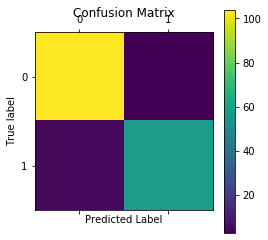

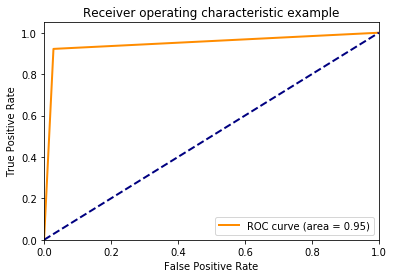

Mean Accuracy metic has value of 0.953
F1 metic has value of 0.937
AUC metic has value of 0.947
Confusion Matrix
[[104   3]
 [  5  59]]


In [0]:
results_X = LogitModel(X, Y)

<b> Wyniki dla X_pca </b>


[LibLinear]

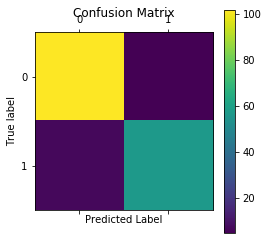

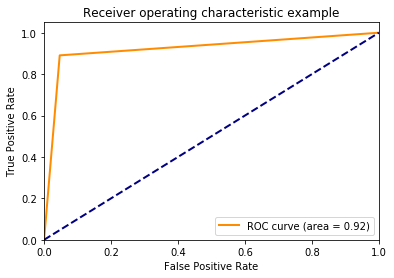

Mean Accuracy metic has value of 0.930
F1 metic has value of 0.905
AUC metic has value of 0.922
Confusion Matrix
[[102   5]
 [  7  57]]


In [0]:
results_PCA = LogitModel(X_pca, Y)

<b>Wyniki dla X_mds</b>

[LibLinear]

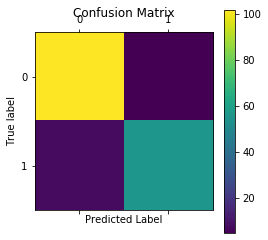

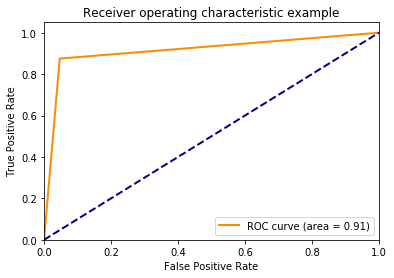

Mean Accuracy metic has value of 0.924
F1 metic has value of 0.896
AUC metic has value of 0.914
Confusion Matrix
[[102   5]
 [  8  56]]


In [0]:
results_MDS = LogitModel(X_mds,Y)

<b>Wyniki dla X_tree</b>

[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


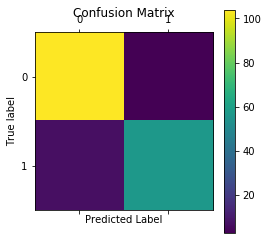

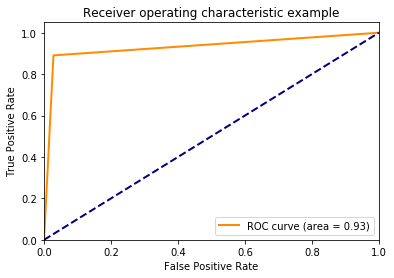

Mean Accuracy metic has value of 0.942
F1 metic has value of 0.919
AUC metic has value of 0.931
Confusion Matrix
[[104   3]
 [  7  57]]


In [0]:
results_TREE = LogitModel(X_tree,Y)

<b> Wyniki dla X_inf</b>


[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


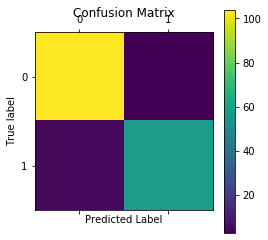

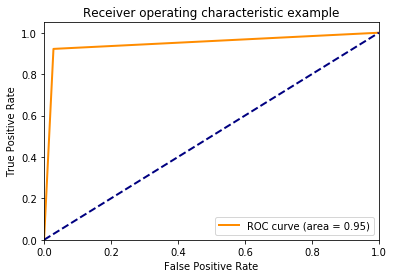

Mean Accuracy metic has value of 0.953
F1 metic has value of 0.937
AUC metic has value of 0.947
Confusion Matrix
[[104   3]
 [  5  59]]


In [47]:
results_Inf = LogitModel(X_inf,Y)